In [1]:
# import TensorFlow as TF
import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np
import statistics
from statistics import mean, median


from sklearn import datasets
from sklearn.impute import SimpleImputer # used for handling missing data


In [2]:

df = pd.read_csv('data.csv')
data_top = df.head()
copy = df.copy() 

# 1 - Remove rows where the target column (Scope1) is NaN.

#copy = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
#copy = copy.reset_index() 

# 2 - Replace all NaN from the attribute columns and replace for mean of that column

# copy = copy.fillna(copy.mean())
# col_names = copy.columns
# sub2[col_names].fillna((sub2[col_names].mean()), inplace=True)

# create dictionary with 
def create_dict(target_var, df): 
    org_ids = list(df[target_var]) 
    list_set = set(org_ids) # get unique elements
    unique = list(list_set) # place them in a list 
    df = df.groupby([target_var]) 
    
    dictionary = {} 
    for item in unique:
        df_id = df.get_group(item)
        df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])
                
        df_id = df_id.sort_values(by="StatementDetails.FinancialPeriodEndDate")
        dictionary[item] = df_id
    
    return dictionary

dict_id = create_dict('organization_id', copy)
print(dict_id[14346])

#print(copy.organzation_id)

#key_list = list(GTAP_sector_dict.keys())

#print(key_list)

#print(GTAP_sector_dict)

# in the dictionary, we want to replace all the NaN of the values for the means of those columns.


# # check missing values >> columns with lots of missing values are not useful. 
# missing_values_df = copy.isnull().sum().sort_values(ascending=False).head()
# print(missing_values_df)

# # replace NaN in column for mean of column with Imputer 
# imp = SimpleImputer(missing_values='NaN', strategy='mean')
# imp = imp.fit(copy)



#print(replace_NaN(GTAP_sector_dict))    



/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_21117/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])


       organization_id StatementDetails.FinancialPeriodEndDate  \
66052            14346               2018-12-31 00:00:00+00:00   
29557            14346               2019-12-31 00:00:00+00:00   

       StatementDetails.FinancialPeriodFiscalYear  \
66052                                        2018   
29557                                        2019   

       StatementDetails.FinancialPeriodIsIncomplete  \
66052                                         False   
29557                                         False   

      StatementDetails.EsgOrAtdIndicator  EmissionDataPoints.AccidentalSpills  \
66052                                ESG                                  NaN   
29557                                ESG                                  NaN   

      EmissionDataPoints.AnalyticCO2EstimationMethod  \
66052                                         Median   
29557                                       Reported   

       EmissionDataPoints.AnalyticEstimatesCO2EquivalentsEmiss

In [3]:
# function for filling NaN's
def fill_nan(df, column_name):
    mean_value=df[column_name].mean()
    df[column_name].fillna(value=mean_value, inplace=True)
    return df

# function for determining percentage NaN
def ratio_nan(df, column_name):
    ratio = df[column_name].isnull().sum() / len(df)
    return ratio

# function to loop over org_ids and creat df with ratio's nan in column
def dict_ratios(dictionary, column_name):
    dict_ratios = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        dict_ratios[key] = ratio_key
    return dict_ratios

#print(np.array(list(dict_ratios(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1').values())).mean())
#print(dict_ratios(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'))

def df_clean(df, column_name):
    df = df.reset_index(drop=True)
    
    for i in range(1, len(df[column_name])-2):
        if math.isnan(df.at[i, column_name]):
            if not math.isnan(df.at[i-1, column_name]):
                if not math.isnan(df.at[i+1, column_name]):
                    mean = (df.at[i+1, column_name] + df.at[i-1, column_name])/2
                    df.at[i, column_name] = mean
                    
#     if math.isnan(df.at[0, column_name]):
#         if not math.isnan(df.at[1, column_name]):
#             df.at[0, column_name] = df.at[1, column_name]
            
#     last_point = len(df[column_name]) - 1
    
#     if math.isnan(df.at[last_point, column_name]):
#         if not math.isnan(df.at[last_point-1, column_name]):
#             df.at[last_point, column_name] = df.at[last_point-1, column_name]
    
    df = df[df[column_name].notna()]
    return df

def dict_clean_better(dictionary, column_name, ratio):
    dict_clean = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        if ratio_key <= ratio:
            dict_clean[key] = df_clean(dictionary[key], column_name)
        else:
            df_key = dictionary[key]
            df_key = df_key[df_key[column_name].notna()]
            dict_clean[key] = df_key
    return dict_clean

def dict_clean_final(dictionary, column_name):
    dict_clean = {}
    for key in dictionary:
        dict_clean[key] = df_clean(dictionary[key], column_name)
    return dict_clean

def dict_clean_mean(dictionary, column_name, ratio):
    dict_clean = {}
    for key in dictionary:
        ratio_key = ratio_nan(dictionary[key], column_name)
        if ratio_key <= ratio:
            dict_clean[key] = fill_nan(dictionary[key], column_name)
        else:
            df_key = dictionary[key]
            df_key = df_key[df_key[column_name].notna()]
            dict_clean[key] = df_key
    return dict_clean


dict_nan = dict_clean_better(dict_id, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', 0.2)


# print(ratio_nan(dict_id[6230], 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'))

# df_6230 = dict_id[6230]
# df_clean_6230 = dict_nan[6230]

df_72 = dict_id[72]
df_clean_72 = dict_nan[72]

#print(df_72['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])
#print(df_clean_72['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])




In [4]:
#copy.groupby("organization_id")['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].plot(x='StatementDetails.FinancialPeriodFiscalYear',y='EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
# .mean()

#print(list(copy.columns))


df = df[df['organization_id'].notna()]


def find_correlation(df, target_value,):
    # way to determine if columns have correlation
    df_target = df[target_value]
    corr = df.corrwith(df_target)
    return corr

#print(dict(find_correlation(dict_nan[6230], 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')))



In [5]:
from datetime import datetime

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error

# dict_id = create_dict('GTAP sector', copy)
# air = dict_id['Air transport']
# print(air)
# Y = air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
# X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]

# X = np.array(X)
# # X = X.reshape(-1,1) # alleen voor 1 input variable
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
# degree = 5
# polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
# polyreg.fit(X_train,Y_train)
# predictions = polyreg.predict(X_test)

# # print("Coefficients: \n", polyreg.coef_)
# # The mean squared error
# print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

# plt.scatter(X_test[:, 0], predictions, label='prediction')
# plt.scatter(X_test[:, 0], Y_test, label='test data')

# plt.xlabel("year")
# plt.ylabel("CO2 emission")
# plt.legend()
# plt.show()

In [6]:
def manage_outliers(df, column_name, d_max):
    df = df.reset_index(drop=True)
    for i in range(len(df[column_name])-1):
        x = df.at[i, column_name]
        x_hat = df[column_name].mean()
        stddv = statistics.stdev(df[column_name])
        d_x = (x - x_hat)/stddv
        if d_x > d_max:
            df = df.drop(i)
    return df

dict_id = create_dict('GTAP sector', copy)
air = dict_id['Air transport']
air = df_clean(air, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

print(air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])

air_outliers = manage_outliers(air, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', 0.1)
#print(air_outliers)
print(air_outliers['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'])



/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_21117/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])


11      7000000.0
18      9700000.0
22      6700000.0
28     10200000.0
32      6130968.0
          ...    
548    16315296.0
552     3176634.0
553     9276620.0
556     1995197.0
572    11020000.0
Name: EmissionDataPoints.CO2EquivalentsEmissionDirectScope1, Length: 364, dtype: float64
0       7000000.00
1       9700000.00
2       6700000.00
3      10200000.00
4       6130968.00
          ...     
357     3524184.00
358      310626.37
360     3176634.00
362     1995197.00
363    11020000.00
Name: EmissionDataPoints.CO2EquivalentsEmissionDirectScope1, Length: 201, dtype: float64


Mean absolute error: 12336471.29
Coefficient of determination: 0.00


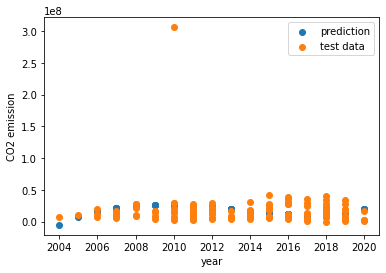

In [7]:
Y = air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]

X = np.array(X)
# X = X.reshape(-1,1) # alleen voor 1 input variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
degree = 5
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,Y_train)
predictions = polyreg.predict(X_test)

# print("Coefficients: \n", polyreg.coef_)
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

plt.scatter(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()

In [8]:
def manage_outliers(dictionary, column_name):
    dictionary_out = {}
    for key in dictionary:
        df = dictionary[key]
        if len(df) > 2:
            df = df.reset_index(drop=True)
            x_hat = df[column_name].mean()
            stddv = statistics.stdev(df[column_name])
            for i in range(len(df[column_name])-1):
                x = df.at[i, column_name]
                d_x = (x - x_hat)/stddv
                if d_x > 3:
                    df = df.drop(i)
        
        dictionary_out[key] = df
    return dictionary_out

In [9]:
copy2 = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
copy3 = df.copy()
dict_id2 = create_dict('organization_id', copy3)
dict_id2 = dict_clean_final(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
sector_dict = create_dict('GTAP sector', copy)
dict_id2 = manage_outliers(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
sector_dict = manage_outliers(sector_dict, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_21117/3953964208.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])
/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_21117/2477954813.py:11: RuntimeWarning: invalid value encountered in double_scalars
  d_x = (x - x_hat)/stddv


In [10]:
# copy2 = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column
# copy3 = df.copy()
# dict_id2 = create_dict('organization_id', copy3)
# dict_id2 = dict_clean_final(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
# sector_dict = create_dict('GTAP sector', copy3)
# sector_dict = dict_clean_final(sector_dict, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

# # for key in dict_id2:
# #     if len(dict_id2[key])==0:
# #         del dict_id2[key]


        
# dict_id2 = {k: v for k, v in dict_id2.items() if len(v) > 0}


# print(dict_id2[2760])

In [37]:

#dict_id2 = dict_clean_better(dict_id3, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1', ratio)

#Adds column to df which contains the scaled Emissions based on sector (Assuming sector input) 
def scale_emissions(df):
    df['CO2toRevenue'] = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']*(df['EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues']/df['EmissionDataPoints.CO2EquivalentsEmissionTotal'])
    return df

#Takes threshold in order to determine if you want to use sector or org_id
# returns true if you need to use sector

def sector_or_orgid(orgid, df, threshold = 10):
#     len(df[df['organization_id']==orgid])
    return len(df[df['organization_id']==orgid]) >= threshold

# func: makes predictions for a given org_id
# params: a dict of all org_id's as keys with their corresponding df's as values, and a specific org_id
# returns: the predictions and a plot of the predictions 
def predict(dictionary, orgid): 
    # decide wether to use sector or org_id for predictions:
    if sector_or_orgid(orgid, dictionary[orgid]):      
        print('predictions based on orgid')
        df = dictionary[orgid]
        df = df_clean(df, 'StatementDetails.FinancialPeriodFiscalYear')
        df = df_clean(df, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
        X = df.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]
        X = np.array(X)
        Y = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
        title = 'Plot of emissions for company: ' + str(orgid)
        y_label = "CO2 emission"
    else: 
        print('predictions based on sector (using scaled data)')
        sector = copy['GTAP sector'].loc[orgid]
        
        df_sector = scale_emissions(sector_dict[sector])
        df_sector = df_clean(df_sector, 'CO2toRevenue')
        X = df_sector.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]
        # use scaled emissions as target instead of scope1
        Y = df_sector['CO2toRevenue']
        title = 'Emissions for all companies in the sector: ' + sector
        y_label = 'CO2 emission per revenue'
        
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
    degree = 10
    polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train,Y_train)
    predictions = polyreg.predict(X_test)
    mean_abs_error = mean_absolute_error(Y_test, predictions)
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))
#     plt.plot(X_test, predictions, label='prediction')
#     plt.scatter(X_test, Y_test, label='test data')
#     #X_test[:, 0]
#     plt.xlabel("year")
#     plt.ylabel(y_label)
#     plt.title(title)
#     plt.legend()
#     plt.show()
    return predictions, mean_abs_error



    
#dict_test = create_dict('organization_id', copy2)
# print(predict(dict_id2, 2964))

In [38]:
abs_error_list = []
sugar_list = [27010, 75442, 68567, 23371, 21577, 96772, 26975, 73241, 53463, 84588, 64890, 79710, 21053, 84455, 11705, 19740, 59012, 2759, 48338, 3515, 92018, 69444]
# list(sector_dict['Sugar']['organization_id'])
for key in dict_id2:
    print(key)
    if key in sugar_list:
        continue
    if len(dict_id2[key]) == 0:
        continue
    else: 
        abs_error_list.append(predict(dict_id2, key)[1])
    
print(abs_error_list)

1
2
3
4
5
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
6
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
7
8
9
10
11
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
12
13
14
15
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
16
17
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
18
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
19
20
predictions based on sector (using scaled data)
Mean absolute error: 283.14
Coefficient of determination: -0.04
21
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
22
23
24
25
26
27
28
29
predictions based on sector (usin

Mean absolute error: 436279.84
Coefficient of determination: 0.67
230
predictions based on orgid
Mean absolute error: 1185.60
Coefficient of determination: 0.54
231
232
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
233
234
235
236
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
237
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
238
239
240
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
241
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
242
243
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
244
245
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.

Mean absolute error: 535.87
Coefficient of determination: -0.00
480
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
481
482
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
483
484
predictions based on orgid
Mean absolute error: 13503.67
Coefficient of determination: -0.79
485
486
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
487
488
489
490
491
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
492
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
493
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
494
495
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
496


Mean absolute error: 17.68
Coefficient of determination: 0.00
654
655
predictions based on orgid
Mean absolute error: 125440.12
Coefficient of determination: 0.74
656
657
658
659
660
661
predictions based on sector (using scaled data)
Mean absolute error: 1217.93
Coefficient of determination: -5.50
662
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
663
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
664
predictions based on sector (using scaled data)
Mean absolute error: 301.89
Coefficient of determination: -0.03
665
666
predictions based on orgid
Mean absolute error: 1683836.04
Coefficient of determination: -6.06
667
predictions based on sector (using scaled data)
Mean absolute error: 135.53
Coefficient of determination: 0.05
668
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
669
predictions based

Mean absolute error: 535.87
Coefficient of determination: -0.00
837
838
predictions based on orgid
Mean absolute error: 331865.95
Coefficient of determination: 0.03
839
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
840
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
841
predictions based on orgid
Mean absolute error: 29525049.07
Coefficient of determination: -43.77
842
843
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
844
845
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
846
predictions based on orgid
Mean absolute error: 1682188.45
Coefficient of determination: 0.79
847
predictions based on orgid
Mean absolute error: 2954.13
Coefficient of determination: 0.59
848
849
predictions based on orgid
Mean absolute error: 821447.80
Coeff

Mean absolute error: 62.92
Coefficient of determination: -0.01
1064
1065
1066
1067
1068
1069
predictions based on orgid
Mean absolute error: 1208.82
Coefficient of determination: -2.39
1070
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
1071
1072
1073
1074
1075
1076
1077
1078
1079
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1090
1091
1092
1093
predictions based on sector (using scaled data)
Mean absolute error: 3.94
Coefficient of determination: -0.07
1094
1095
1096
1097
1098
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
1099
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1100


Mean absolute error: 535.87
Coefficient of determination: -0.00
1321
1322
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
1323
1324
1325
1326
1327
1328
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
1329
1330
1331
1332
1333
1334
1335
1336
predictions based on orgid
Mean absolute error: 45684.64
Coefficient of determination: 0.67
1337
1338
1339
1340
1341
1342
1343
1344
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
1361
1362
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
1363
1364
1365
predictions based on sector (using scaled data)
Mean absolute e

Mean absolute error: 535.87
Coefficient of determination: -0.00
1622
predictions based on orgid
Mean absolute error: 137314.69
Coefficient of determination: -0.05
1623
1624
1625
1626
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
1627
predictions based on orgid
Mean absolute error: 1436.47
Coefficient of determination: 0.68
1628
predictions based on orgid
Mean absolute error: 4322.61
Coefficient of determination: 0.88
1629
predictions based on orgid
Mean absolute error: 1691174.90
Coefficient of determination: 0.90
1630
predictions based on orgid
Mean absolute error: 15250.96
Coefficient of determination: -14.90
1631
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
1632
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
1633
1634
predictions based on orgid
Mean absolute error: 689598.23
Coefficient of d

Mean absolute error: 111.20
Coefficient of determination: -0.00
1740
predictions based on orgid
Mean absolute error: 32576.06
Coefficient of determination: -38.61
1741
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
1742
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
1743
predictions based on sector (using scaled data)
Mean absolute error: 5934.80
Coefficient of determination: -0.03
1744
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
1745
predictions based on orgid
Mean absolute error: 25322.77
Coefficient of determination: 0.43
1746
predictions based on orgid
Mean absolute error: 49207.38
Coefficient of determination: -2.04
1747
predictions based on orgid
Mean absolute error: 423889.94
Coefficient of determination: -35.55
1748
predictions based on orgid
Mean absolute error: 1808.35
Coefficient of deter

Mean absolute error: 535.87
Coefficient of determination: -0.00
1840
predictions based on orgid
Mean absolute error: 3740.59
Coefficient of determination: -0.53
1841
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
1842
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
1843
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
1844
predictions based on orgid
Mean absolute error: 21166.36
Coefficient of determination: 0.80
1845
1846
1847
1848
predictions based on orgid
Mean absolute error: 2992.17
Coefficient of determination: 0.62
1849
predictions based on orgid
Mean absolute error: 14991714.70
Coefficient of determination: -1.15
1850
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
1851
predictions based on orgid
Mean absolute error: 12915.97
Coe

Mean absolute error: 335.23
Coefficient of determination: 0.00
1955
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
1956
predictions based on orgid
Mean absolute error: 1127021.10
Coefficient of determination: -0.35
1957
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
1958
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
1959
1960
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
1961
1962
predictions based on sector (using scaled data)
Mean absolute error: 31.56
Coefficient of determination: -0.16
1963
1964
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
1965
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
1966
predic

Mean absolute error: 535.87
Coefficient of determination: -0.00
2092
predictions based on orgid
Mean absolute error: 2034557.10
Coefficient of determination: 0.36
2093
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
2094
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
2095
2096
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2097
2098
2099
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
2100
2101
2102
2103
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
2104
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
2105
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination:

Mean absolute error: 111.20
Coefficient of determination: -0.00
2251
predictions based on orgid
Mean absolute error: 2120038.27
Coefficient of determination: -41.15
2252
2253
2254
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
2255
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
2256
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
2257
2258
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
2259
2260
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2261
2262
predictions based on sector (using scaled data)
Mean absolute error: 961.50
Coefficient of determination: 0.02
2263
2264
2265
2266
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of deter

Mean absolute error: 111.20
Coefficient of determination: -0.00
2441
predictions based on orgid
Mean absolute error: 585337.14
Coefficient of determination: -4259.48
2442
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2443
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
2444
predictions based on sector (using scaled data)
Mean absolute error: 260.86
Coefficient of determination: 0.02
2445
2446
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
2447
2448
2449
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2450
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
2451
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
2452
2

Mean absolute error: 335.23
Coefficient of determination: 0.00
2558
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
2559
2560
2561
predictions based on sector (using scaled data)
Mean absolute error: 106.38
Coefficient of determination: -0.55
2562
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2563
2564
2565
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
2566
2567
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2568
2569
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2570
2571
predictions based on orgid
Mean absolute error: 14755.54
Coefficient of determination: -0.66
2572
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determina

Mean absolute error: 535.87
Coefficient of determination: -0.00
2675
predictions based on orgid
Mean absolute error: 15457.08
Coefficient of determination: 0.03
2676
predictions based on orgid
Mean absolute error: 7873.05
Coefficient of determination: 0.10
2677
predictions based on orgid
Mean absolute error: 1394564.09
Coefficient of determination: -58.09
2678
predictions based on orgid
Mean absolute error: 4752608.04
Coefficient of determination: -874.28
2679
2680
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
2681
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
2682
predictions based on orgid
Mean absolute error: 410809.20
Coefficient of determination: 0.26
2683
predictions based on orgid
Mean absolute error: 9542777.98
Coefficient of determination: -1301.73
2684
predictions based on sector (using scaled data)
Mean absolute error: 10.75
Coefficient of determ

Mean absolute error: 535.87
Coefficient of determination: -0.00
2805
2806
predictions based on orgid
Mean absolute error: 3914.77
Coefficient of determination: -1.68
2807
2808
2809
2810
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
2811
2812
2813
predictions based on sector (using scaled data)
Mean absolute error: 593.49
Coefficient of determination: 0.05
2814
2815
predictions based on sector (using scaled data)
Mean absolute error: 301.89
Coefficient of determination: -0.03
2816
2817
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
2818
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2819
2820
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
2821
2822
2823
2824
2825
predictions based on sector (using scaled data)
Mean absolute error: 535.87

Mean absolute error: 0.53
Coefficient of determination: 0.01
2949
2950
2951
2952
2953
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
2954
predictions based on orgid
Mean absolute error: 157948.31
Coefficient of determination: -7.99
2955
2956
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
2957
2958
2959
predictions based on orgid
Mean absolute error: 167311.65
Coefficient of determination: -41.86
2960
2961
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
2962
predictions based on orgid
Mean absolute error: 32641.45
Coefficient of determination: 0.24
2963
predictions based on orgid
Mean absolute error: 2041098.23
Coefficient of determination: -11.31
2964
predictions based on orgid
Mean absolute error: 2860.29
Coefficient of determination: 0.81
2965
2966
predictions based on orgid
Mean absolute error: 

Mean absolute error: 2335.26
Coefficient of determination: -0.01
3080
predictions based on orgid
Mean absolute error: 8346.19
Coefficient of determination: -3.21
3081
predictions based on orgid
Mean absolute error: 6346.81
Coefficient of determination: -2.54
3082
3083
3084
3085
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
3086
3087
3088
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
3089
3090
predictions based on orgid
Mean absolute error: 766824.65
Coefficient of determination: -0.07
3091
predictions based on orgid
Mean absolute error: 120642.36
Coefficient of determination: 0.36
3092
predictions based on sector (using scaled data)
Mean absolute error: 750.54
Coefficient of determination: -0.05
3093
3094
3095
3096
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
3097
predictions based on sector (u

Mean absolute error: 17.68
Coefficient of determination: 0.00
3226
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3227
3228
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3229
predictions based on orgid
Mean absolute error: 512.28
Coefficient of determination: 0.82
3230
predictions based on orgid
Mean absolute error: 135912.65
Coefficient of determination: -1.52
3231
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3232
3233
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3234
predictions based on orgid
Mean absolute error: 628690.55
Coefficient of determination: 0.22
3235
3236
predictions based on sector (using scaled data)
Mean absolute error: 10.75
Coefficient of determination: -0.03
3237
predictions based on orgid
Mean absolute error

Mean absolute error: 535.87
Coefficient of determination: -0.00
3348
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
3349
3350
3351
3352
3353
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3354
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
3355
3356
3357
3358
3359
predictions based on sector (using scaled data)
Mean absolute error: 95.08
Coefficient of determination: -0.01
3360
3361
3362
3363
3364
predictions based on sector (using scaled data)
Mean absolute error: 593.49
Coefficient of determination: 0.05
3365
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
3366
3367
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
3368
3369
3370
3371
3372
3373
3374
predictions based on s

Mean absolute error: 17.68
Coefficient of determination: 0.00
3483
3484
3485
3486
3487
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
3488
predictions based on sector (using scaled data)
Mean absolute error: 11.82
Coefficient of determination: 0.01
3489
3490
3491
predictions based on sector (using scaled data)
Mean absolute error: 19.60
Coefficient of determination: -0.03
3492
3493
predictions based on sector (using scaled data)
Mean absolute error: 2335.26
Coefficient of determination: -0.01
3494
3495
3496
3497
3498
predictions based on orgid
Mean absolute error: 877936.94
Coefficient of determination: -1.14
3499
3500
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3501
3502
3503
3504
predictions based on sector (using scaled data)
Mean absolute error: 2505.85
Coefficient of determination: -0.02
3505
3506
3507
3508
3509
3510
predictions based on sector (usin

Mean absolute error: 535.87
Coefficient of determination: -0.00
3632
3633
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
3634
predictions based on orgid
Mean absolute error: 29419.78
Coefficient of determination: -4.35
3635
predictions based on sector (using scaled data)
Mean absolute error: 283.14
Coefficient of determination: -0.04
3636
predictions based on sector (using scaled data)
Mean absolute error: 593.49
Coefficient of determination: 0.05
3637
3638
3639
predictions based on orgid
Mean absolute error: 132814.53
Coefficient of determination: -16.17
3640
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
3641
predictions based on orgid
Mean absolute error: 9523.23
Coefficient of determination: -0.59
3642
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
3643
3644
predictions based on orgid
Mean abs

Mean absolute error: 535.87
Coefficient of determination: -0.00
3728
3729
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
3730
predictions based on orgid
Mean absolute error: 1014674.44
Coefficient of determination: 0.93
3731
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
3732
3733
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3734
predictions based on orgid
Mean absolute error: 3752996.33
Coefficient of determination: 0.04
3735
predictions based on sector (using scaled data)
Mean absolute error: 135.53
Coefficient of determination: 0.05
3736
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
3737
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
3738
predictions based on sector

Mean absolute error: 335.23
Coefficient of determination: 0.00
3834
3835
predictions based on orgid
Mean absolute error: 2754.92
Coefficient of determination: 0.32
3836
3837
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3838
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
3839
3840
3841
predictions based on sector (using scaled data)
Mean absolute error: 1217.93
Coefficient of determination: -5.50
3842
predictions based on sector (using scaled data)
Mean absolute error: 77.64
Coefficient of determination: -0.13
3843
predictions based on orgid
Mean absolute error: 152502.52
Coefficient of determination: -15.94
3844
predictions based on sector (using scaled data)
Mean absolute error: 719.30
Coefficient of determination: 0.01
3845
predictions based on orgid
Mean absolute error: 675785.83
Coefficient of determination: 0.58
3846
predictions based on orgid
Mean abs

Mean absolute error: 535.87
Coefficient of determination: -0.00
3958
3959
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
3960
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
3961
3962
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
3963
3964
3965
3966
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
3967
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
3968
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
3969
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
3970
3971
3972
3973
predictions based on orgid
Mean absolute error: 8148.87
Coefficient of determina

Mean absolute error: 116.78
Coefficient of determination: -3.05
4087
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
4088
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4089
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4090
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
4091
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
4092
predictions based on orgid
Mean absolute error: 90730.17
Coefficient of determination: -2.08
4093
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4094
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
4095
predictions based on s

Mean absolute error: 335.23
Coefficient of determination: 0.00
4212
predictions based on orgid
Mean absolute error: 22970.93
Coefficient of determination: -49.98
4213
4214
4215
4216
predictions based on sector (using scaled data)
Mean absolute error: 3.94
Coefficient of determination: -0.07
4217
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
4218
predictions based on orgid
Mean absolute error: 5495.95
Coefficient of determination: -5.36
4219
4220
4221
predictions based on orgid
Mean absolute error: 15716.91
Coefficient of determination: -4.26
4222
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
4223
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
4224
predictions based on sector (using scaled data)
Mean absolute error: 8.37
Coefficient of determination: -0.24
4225
predictions based on sector (using 

Mean absolute error: 17.68
Coefficient of determination: 0.00
4336
predictions based on orgid
Mean absolute error: 555.60
Coefficient of determination: -0.56
4337
predictions based on sector (using scaled data)
Mean absolute error: 2335.26
Coefficient of determination: -0.01
4338
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
4339
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
4340
predictions based on orgid
Mean absolute error: 56091.22
Coefficient of determination: -0.39
4341
4342
4343
4344
predictions based on sector (using scaled data)
Mean absolute error: 260.86
Coefficient of determination: 0.02
4345
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
4346
predictions based on sector (using scaled data)
Mean absolute error: 593.49
Coefficient of determination: 0.05
4347
predictions based on sect

Mean absolute error: 535.87
Coefficient of determination: -0.00
4436
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
4437
predictions based on orgid
Mean absolute error: 20291.03
Coefficient of determination: 0.77
4438
predictions based on orgid
Mean absolute error: 640.40
Coefficient of determination: -0.23
4439
predictions based on orgid
Mean absolute error: 32636.71
Coefficient of determination: -3.20
4440
predictions based on orgid
Mean absolute error: 49785.92
Coefficient of determination: -13.42
4441
predictions based on orgid
Mean absolute error: 242980.66
Coefficient of determination: -0.13
4442
predictions based on sector (using scaled data)
Mean absolute error: 301.89
Coefficient of determination: -0.03
4443
4444
predictions based on orgid
Mean absolute error: 5298.82
Coefficient of determination: 0.95
4445
predictions based on orgid
Mean absolute error: 865.60
Coefficient of determination: -44.55
4446
predictions

Mean absolute error: 535.87
Coefficient of determination: -0.00
4550
predictions based on orgid
Mean absolute error: 9554.59
Coefficient of determination: -56.42
4551
predictions based on sector (using scaled data)
Mean absolute error: 719.30
Coefficient of determination: 0.01
4552
4553
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
4554
4555
predictions based on orgid
Mean absolute error: 104415.78
Coefficient of determination: 0.89
4556
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
4557
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
4558
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
4559
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
4560
4561
predictions based on sector 

Mean absolute error: 17.68
Coefficient of determination: 0.00
4674
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
4675
predictions based on sector (using scaled data)
Mean absolute error: 260.86
Coefficient of determination: 0.02
4676
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
4677
4678
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
4679
predictions based on sector (using scaled data)
Mean absolute error: 1217.93
Coefficient of determination: -5.50
4680
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
4681
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
4682
4683
4684
predictions based on orgid
Mean absolute error: 33.25
Coefficient of determination: -0.39
4685
4686
pred

Mean absolute error: 535.87
Coefficient of determination: -0.00
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
5191
5192
5193
5194
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
predictions based on orgid
Mean absolute error: 1520647.57
Coefficient of determination: -0.70
5220
predictions based on orgid
Mean absolute error: 167296.45
Coefficient of determination: -12.11
5221
5222
5223
5224
5225
5226
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
5227
5228
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
5229
5230
5231
5232
5233
5234
5235
predictions

Mean absolute error: 23.65
Coefficient of determination: -0.00
5761
predictions based on orgid
Mean absolute error: 219101.21
Coefficient of determination: -1.19
5762
5763
predictions based on orgid
Mean absolute error: 392441.49
Coefficient of determination: 0.83
5764
5765
5766
predictions based on sector (using scaled data)
Mean absolute error: 1217.93
Coefficient of determination: -5.50
5767
5768
5769
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
5770
5771
5772
5773
5774
5775
5776
predictions based on orgid
Mean absolute error: 110871.35
Coefficient of determination: -0.45
5777
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
5778
5779
5780
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
5781
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determinati

Mean absolute error: 535.87
Coefficient of determination: -0.00
5954
5955
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
5956
5957
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
5958
5959
predictions based on orgid
Mean absolute error: 17570.10
Coefficient of determination: 0.74
5960
5961
5962
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
5963
5964
5965
predictions based on orgid
Mean absolute error: 56391.21
Coefficient of determination: 0.86
5966
predictions based on orgid
Mean absolute error: 15643.47
Coefficient of determination: -22.11
5967
5968
5969
5970
5971
predictions based on orgid
Mean absolute error: 32449.44
Coefficient of determination: -1.46
5972
5973
5974
5975
5976
5977
5978
predictions based on orgid
Mean absolute error: 32165.88
Coefficient of determination: -37.85
5979
5980
5981
5

Mean absolute error: 40.45
Coefficient of determination: -0.01
6240
6241
6242
6243
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
6244
6245
6246
6247
6248
6249
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
6250
6251
6252
6253
6254
6255
6256
predictions based on orgid
Mean absolute error: 3218579.43
Coefficient of determination: -0.51
6257
6258
6259
6260
6261
6262
6263
predictions based on orgid
Mean absolute error: 4179.76
Coefficient of determination: 0.86
6264
6265
predictions based on sector (using scaled data)
Mean absolute error: 10.75
Coefficient of determination: -0.03
6266
predictions based on orgid
Mean absolute error: 12101.22
Coefficient of determination: -1.05
6267
predictions based on sector (using scaled data)
Mean absolute error: 3.94
Coefficient of determination: -0.07
6268
6269
6270
predictions based on orgid
Mean absolute error: 1011.81
Coeffic

Mean absolute error: 0.53
Coefficient of determination: 0.01
6472
6473
6474
predictions based on sector (using scaled data)
Mean absolute error: 142.96
Coefficient of determination: 0.00
6475
predictions based on orgid
Mean absolute error: 57379.31
Coefficient of determination: 0.33
6476
predictions based on orgid
Mean absolute error: 624842.10
Coefficient of determination: -0.99
6477
predictions based on orgid
Mean absolute error: 335374.03
Coefficient of determination: -21.84
6478
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
6479
6480
predictions based on orgid
Mean absolute error: 3364533.95
Coefficient of determination: -1.49
6481
6482
6483
6484
6485
6486
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
6487
6488
predictions based on orgid
Mean absolute error: 3791745.00
Coefficient of determination: -2.51
6489
6490
6491
predictions based on orgid
Mean abs

Mean absolute error: 40.45
Coefficient of determination: -0.01
6751
6752
6753
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
6754
6755
6756
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
6757
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
6758
6759
predictions based on sector (using scaled data)
Mean absolute error: 2505.85
Coefficient of determination: -0.02
6760
predictions based on sector (using scaled data)
Mean absolute error: 961.50
Coefficient of determination: 0.02
6761
6762
6763
6764
6765
6766
6767
6768
predictions based on orgid
Mean absolute error: 10554.88
Coefficient of determination: -826.41
6769
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
6770
6771
6772
predictions based on sector (using scaled data)
Mean absolute e

Mean absolute error: 335.23
Coefficient of determination: 0.00
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
predictions based on sector (using scaled data)
Mean absolute error: 135.53
Coefficient of determination: 0.05
7303
predictions based on sector (using scaled data)
Mean absolute error: 148.75
Coefficient of determination: -0.12
7304
7305
7306
7307
7308
7309
7310
predictions based on orgid
Mean absolute error: 3796.65
Coefficient of determination: 0.55
7311
7312
7313
7314
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
7336
predictions based on orgid
Mean absolute error: 233976.51
Coefficient of determination: -0.67
7337
7338
7339
7340
7341
7342
7343


Mean absolute error: 23.65
Coefficient of determination: -0.00
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
predictions based on sector (using scaled data)
Mean absolute error: 246.49
Coefficient of determination: -0.08
7899
7900
7901
7902
7903
7904
7905
7906
7907
predictions 

Mean absolute error: 23.65
Coefficient of determination: -0.00
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
predictions based on orgid
Mean absolute error: 94399.62
Coefficient of determination: 0.82
8230
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
8231
8232
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
8233
8234
8235
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
8236
8237
8238
8239
8240
8241
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
8242
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
8243
predictions based on orgid
Mean absolute error: 2438318.30
Coefficient of determination: -1.11
8244
predictions based on orgid
Mean absolute error: 10102.69
Coefficien

Mean absolute error: 17.68
Coefficient of determination: 0.00
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
predictions based on sector (using scaled data)
Mean absolute error: 258.90
Coefficient of determination: 0.00
9324
9325
9326
9327
9328
9329
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
9330
9331
9332
9333
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
9334
9335
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
9336
9337
9338
9339
9340
9341
9342
9343
9344
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
9345
9346
9347
9348
934

predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
9893
9894
9895
9896
9897
9898
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
9976
9977
9978
9979
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
9980
998

Mean absolute error: 17.68
Coefficient of determination: 0.00
10483
10484
10485
10486
10487
10488
10489
predictions based on sector (using scaled data)
Mean absolute error: 283.14
Coefficient of determination: -0.04
10490
10491
10492
10493
10494
10495
10496
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
10497
10498
10499
10500
10501
10502
10503
predictions based on sector (using scaled data)
Mean absolute error: 3.24
Coefficient of determination: 0.19
10504
10505
10506
10507
10508
predictions based on sector (using scaled data)
Mean absolute error: 69.62
Coefficient of determination: 0.01
10509
10510
10511
10512
10513
10514
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
10515
10516
10517
10518
10519
10520
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
10521
10522
predictions based on orgid
Mean ab

Mean absolute error: 260.86
Coefficient of determination: 0.02
11018
11019
11020
11021
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
predictions based on orgid
Mean absolute error: 246.51
Coefficient of determination: 0.30
11054
11055
11056
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
11071
11072
11073
11074
11075
11076
11077
11078
predictions based on sector (using s

Mean absolute error: 535.87
Coefficient of determination: -0.00
11307
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
11308
11309
11310
11311
predictions based on orgid
Mean absolute error: 718930.96
Coefficient of determination: 0.83
11312
11313
11314
11315
predictions based on sector (using scaled data)
Mean absolute error: 8.37
Coefficient of determination: -0.24
11316
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
11317
11318
11319
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
11320
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
11321
11322
predictions based on orgid
Mean absolute error: 362042.59
Coefficient of determination: -4.20
11323
11324
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient 

Mean absolute error: 17.68
Coefficient of determination: 0.00
11486
predictions based on sector (using scaled data)
Mean absolute error: 961.50
Coefficient of determination: 0.02
11487
11488
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
11489
11490
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
11491
11492
11493
11494
11495
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
11496
11497
11498
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
11499
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
11500
11501
11502
11503
11504
11505
11506
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
11507
predictions based on orgid
M

Mean absolute error: 17.68
Coefficient of determination: 0.00
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
11746
11747
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
11748
11749
11750
11751
predictions based on sector (using scaled data)
Mean absolute error: 2335.26
Coefficient of determination: -0.01
11752
11753
11754
11755
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
11756
11757
11758
11759
11760
11761
11762
11763
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
11764
11765
11766
predictions based on secto

Mean absolute error: 535.87
Coefficient of determination: -0.00
12061
12062
predictions based on orgid
Mean absolute error: 6582.15
Coefficient of determination: -1.45
12063
12064
12065
12066
12067
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
12068
12069
12070
12071
12072
12073
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
12074
12075
12076
12077
12078
12079
12080
predictions based on orgid
Mean absolute error: 234.92
Coefficient of determination: -0.33
12081
12082
12083
12084
12085
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
12086
12087
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
12088
12089
12090
12091
12092
12093
12094
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination

Mean absolute error: 535.87
Coefficient of determination: -0.00
12345
predictions based on orgid
Mean absolute error: 6120792.69
Coefficient of determination: -4.10
12346
12347
12348
12349
12350
12351
12352
12353
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
predictions based on sector (using scaled data)
Mean absolute error: 1217.93
Coefficient of determination: -5.50
12367
12368
12369
12370
12371
12372
12373
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
12374
12375
12376
12377
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
12378
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
12379
12380
12381
12382
12383
12384
12385
12386
12387
predictions based on sector (

Mean absolute error: 111.20
Coefficient of determination: -0.00
12674
predictions based on sector (using scaled data)
Mean absolute error: 77.64
Coefficient of determination: -0.13
12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
12685
12686
12687
12688
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
12689
12690
12691
predictions based on sector (using scaled data)
Mean absolute error: 2335.26
Coefficient of determination: -0.01
12692
12693
12694
12695
12696
12697
12698
12699
12700
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
12722
predictions based on orgid
Mean absolute error: 1126.70
Coefficient of determination:

Mean absolute error: 535.87
Coefficient of determination: -0.00
13082
13083
13084
13085
13086
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
13087
13088
predictions based on sector (using scaled data)
Mean absolute error: 31.56
Coefficient of determination: -0.16
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
13099
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
13100
13101
13102
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
13103
13104
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
13105
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
13106
13107
1310

Mean absolute error: 17.68
Coefficient of determination: 0.00
13387
13388
13389
13390
predictions based on sector (using scaled data)
Mean absolute error: 267.47
Coefficient of determination: 0.05
13391
13392
13393
predictions based on sector (using scaled data)
Mean absolute error: 8.37
Coefficient of determination: -0.24
13394
13395
13396
13397
13398
13399
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
13400
13401
13402
13403
13404
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
13405
predictions based on sector (using scaled data)
Mean absolute error: 2335.26
Coefficient of determination: -0.01
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
predictions based on sector (using scaled data)
Mean absolute error: 301.89
Coefficient of determination: -0.03
13419
predictions based on sector (using scaled data)
Mean absolute error: 0.5

Mean absolute error: 535.87
Coefficient of determination: -0.00
13681
13682
13683
13684
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
13685
13686
13687
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
13688
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
13689
predictions based on orgid
Mean absolute error: 268620.02
Coefficient of determination: -0.78
13690
13691
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
13692
13693
13694
13695
13696
13697
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
13698
13699
13700
13701
predictions based on orgid
Mean absolute error: 144909.66
Coefficient of determination: 0.17
13702
13703
13704
predictions based on sector (using scaled data)
Mean

Mean absolute error: 535.87
Coefficient of determination: -0.00
13957
13958
13959
13960
predictions based on sector (using scaled data)
Mean absolute error: 15.04
Coefficient of determination: 0.02
13961
predictions based on sector (using scaled data)
Mean absolute error: 40.45
Coefficient of determination: -0.01
13962
13963
predictions based on sector (using scaled data)
Mean absolute error: 111.20
Coefficient of determination: -0.00
13964
13965
13966
13967
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of determination: -0.00
13968
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
13969
13970
13971
13972
13973
13974
13975
13976
predictions based on sector (using scaled data)
Mean absolute error: 19.60
Coefficient of determination: -0.03
13977
predictions based on sector (using scaled data)
Mean absolute error: 35.86
Coefficient of determination: 0.02
13978
predictions based on sector

Mean absolute error: 335.23
Coefficient of determination: 0.00
14161
predictions based on orgid
Mean absolute error: 105772.97
Coefficient of determination: -0.22
14162
14163
14164
14165
14166
14167
14168
14169
predictions based on orgid
Mean absolute error: 11745.06
Coefficient of determination: -0.44
14170
14171
14172
14173
14174
14175
14176
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14177
14178
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14179
14180
predictions based on sector (using scaled data)
Mean absolute error: 132.29
Coefficient of determination: -0.17
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
predictions based on sector (using scaled data)
Mean absolute error: 0.53
Coefficient of determination: 0.01
14195
14196
predictions based on sector (using scaled data)
Mean absolute error: 23.65
Coefficient of det

Mean absolute error: 40.45
Coefficient of determination: -0.01
14445
14446
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14447
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
14448
14449
14450
14451
14452
14453
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14454
14455
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14456
14457
14458
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
predictions based on orgid
Mean absolute error: 12759602.56
Coefficient of determination: 0.92
14474
14475
14476
14477
predictions based on orgid
Mean absolute error: 9122.97
Coefficient of determination: -42.5

Mean absolute error: 535.87
Coefficient of determination: -0.00
14685
14686
14687
14688
14689
14690
14691
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
14692
14693
14694
predictions based on orgid
Mean absolute error: 69375.64
Coefficient of determination: 0.80
14695
14696
14697
14698
14699
14700
14701
14702
14703
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
14704
14705
14706
14707
14708
predictions based on sector (using scaled data)
Mean absolute error: 535.87
Coefficient of determination: -0.00
14709
14710
14711
14712
predictions based on sector (using scaled data)
Mean absolute error: 62.92
Coefficient of determination: -0.01
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
predictions based on sector (using scaled data)
Mean absolute error: 17.68
Coefficient of determination: 0.00
14726
predictions based on sector (using s

Mean absolute error: 535.87
Coefficient of determination: -0.00
14919
14920
predictions based on orgid
Mean absolute error: 377.78
Coefficient of determination: 0.97
14921
predictions based on orgid
Mean absolute error: 3552.80
Coefficient of determination: -25.95
14922
predictions based on orgid
Mean absolute error: 20795.38
Coefficient of determination: 0.19
14923
predictions based on orgid
Mean absolute error: 5539.06
Coefficient of determination: -0.08
14924
14925
predictions based on orgid
Mean absolute error: 1966.23
Coefficient of determination: 0.71
14926
predictions based on orgid
Mean absolute error: 633.48
Coefficient of determination: -18.85
14927
predictions based on sector (using scaled data)
Mean absolute error: 335.23
Coefficient of determination: 0.00
14928
predictions based on sector (using scaled data)
Mean absolute error: 2505.85
Coefficient of determination: -0.02
14929
predictions based on orgid
Mean absolute error: 6879.90
Coefficient of determination: -26.42
149

In [39]:
print(mean(abs_error_list))
print(max(abs_error_list))
print(min(abs_error_list))
print(median(abs_error_list))

233936.70130375048
48127834.37988281
0.0
283.14469310847846


In [40]:
print(len(abs_error_list))

4101


In [12]:
print(list(sector_dict['Sugar']['organization_id']))

[1873, 1873, 1873, 1873, 1873, 1873, 1873, 1873, 1873, 1873, 1873, 1873, 5206, 1873, 5206, 1873, 5206, 1873, 1873, 1873, 1873, 1873]


In [16]:
# print(dict_id2[2759])
print(list(sector_dict['Sugar'].index))
print(len(dict_id2[14897]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
0
